In [34]:
# !pip install tensorflow_text=="2.9.*"

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

import preprocess_utils as pre

In [36]:
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

Tensorflow version:  2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
def read_ronec_json_file(file_path):
    tokens = []
    entity_tags = []

    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)

        for element in data:
            tokens.append(element["tokens"])
            entity_tags.append(element["ner_tags"])
    
    return tokens, entity_tags

dir_path = os.path.join("datasets", "ronec")

In [39]:
train_text, train_labels = read_ronec_json_file(os.path.join(dir_path, "train.json"))
print(f"Train dataset: {len(train_text)}")

Train dataset: 9000


In [40]:
valid_text, valid_labels = read_ronec_json_file(os.path.join(dir_path, "valid.json"))
print(f"Validation dataset: {len(valid_text)}")

Validation dataset: 1330


In [41]:
test_text, test_labels = read_ronec_json_file(os.path.join(dir_path, "test.json"))
print(f"Test dataset: {len(test_text)}")

Test dataset: 2000


In [42]:
test_text, test_labels = read_ronec_json_file(os.path.join(dir_path, "test.json"))
print(f"Test dataset: {len(test_text)}")

Test dataset: 2000


In [43]:
print(f"Sentence: {train_text[1]}")
print(f"Labels:   {train_labels[1]}")

Sentence: ['Vechiul', 'oraș', 'Visoki', 'a', 'fost', 'un', 'faimos', 'castel', 'regal', 'medieval', 'în', 'timpul', 'secolului', 'al', 'XIV', '-lea', ',', 'situat', 'în', 'Visoko', ',', 'Bosnia', 'și', 'Herțegovina', '.']
Labels:   ['O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATETIME', 'I-DATETIME', 'I-DATETIME', 'I-DATETIME', 'O', 'O', 'O', 'B-GPE', 'O', 'B-GPE', 'I-GPE', 'I-GPE', 'O']


In [44]:
def get_unique_labels(labels):
    unique_labels = set()
    for sentence_labels in labels:
        unique_labels.update(sentence_labels)
    return unique_labels

unique_labels = sorted(get_unique_labels(train_labels))
label_to_idx = {label: idx+1 for idx, label in enumerate(unique_labels)}
idx_to_label = {idx+1: label for idx, label in enumerate(unique_labels)}

# these tags are important to convert
# the prediction of the model to a string label
label_to_idx

{'B-DATETIME': 1,
 'B-EVENT': 2,
 'B-FACILITY': 3,
 'B-GPE': 4,
 'B-LANGUAGE': 5,
 'B-LOC': 6,
 'B-MONEY': 7,
 'B-NAT_REL_POL': 8,
 'B-NUMERIC': 9,
 'B-ORDINAL': 10,
 'B-ORG': 11,
 'B-PERIOD': 12,
 'B-PERSON': 13,
 'B-QUANTITY': 14,
 'B-WORK_OF_ART': 15,
 'I-DATETIME': 16,
 'I-EVENT': 17,
 'I-FACILITY': 18,
 'I-GPE': 19,
 'I-LANGUAGE': 20,
 'I-LOC': 21,
 'I-MONEY': 22,
 'I-NAT_REL_POL': 23,
 'I-NUMERIC': 24,
 'I-ORDINAL': 25,
 'I-ORG': 26,
 'I-PERIOD': 27,
 'I-PERSON': 28,
 'I-QUANTITY': 29,
 'I-WORK_OF_ART': 30,
 'O': 31}

In [45]:
MAX_SEQ_LENGTH = 30

# tokenizer for small bert
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
tokenizer = hub.KerasLayer(preprocessor.tokenize)
packer = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=MAX_SEQ_LENGTH)
)

# tokenizer for multi bert
# preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
# tokenizer = hub.KerasLayer(preprocessor.tokenize)
# packer = hub.KerasLayer(
#     preprocessor.bert_pack_inputs,
#     arguments=dict(seq_length=MAX_SEQ_LENGTH)
# )

In [46]:
special_tokens = preprocessor.tokenize.get_special_tokens_dict()
print("Special tokens:")
for key, value in special_tokens.items():
    print(f"    {key:20}: {value}")

Special tokens:
    start_of_sequence_id: 101
    vocab_size          : 30522
    end_of_segment_id   : 102
    mask_id             : 103
    padding_id          : 0


In [47]:
TOKEN_START = special_tokens["start_of_sequence_id"]
TOKEN_END = special_tokens["end_of_segment_id"]
TOKEN_PAD = special_tokens["padding_id"]

batch_size = 32

In [48]:
# Merge the last two dimensions of the tokens and
# compute in how many subtoken a word was divided
def merge_dims_and_get_tokens_length(tokens):
    tokens = tokens.merge_dims(-2, -1)
    num_subtokens_per_token = tf.map_fn(lambda token: tf.size(token), tokens, fn_output_signature=tf.int32)
    return tokens, num_subtokens_per_token

# Build a lookup table for labels
init = tf.lookup.KeyValueTensorInitializer(
    keys=unique_labels,
    values=tf.range(1, len(unique_labels) + 1, dtype=tf.int64)
)
table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets=1)

def preprocess_dataset(tokens_info, labels):
    tokens, num_subtokens_per_token = tokens_info
    
    # Bert packer works on batches so a new dimension is necessary
    tokens = tf.expand_dims(tokens, axis=0)
    packed_tokens = packer([tokens])
    # The bert packer already has the output as a batch. This is necessary because
    # we are preprocessing a list of string words (a sentence) instead of a list of
    # string sentences. Thus if we want to batch this sentences we have to reshape.
    packed_tokens["input_word_ids"] = tf.reshape(packed_tokens["input_word_ids"], (-1,))
    packed_tokens["input_type_ids"] = tf.reshape(packed_tokens["input_type_ids"], (-1,))
    packed_tokens["input_mask"] = tf.reshape(packed_tokens["input_mask"], (-1,))
    
    # Convert labels to ids and aligne them to the number of subtokens
    labels_ids = table.lookup(labels)
    aligned_labels_ids = tf.repeat(labels_ids, num_subtokens_per_token)
    # The first token in packed tokens is TOKEN_START and the last is TOKEN_END
    # Also the packed tokens are padded to MAX_SEQUENCE_LENGTH
    logical_pos = tf.logical_and(
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_START),
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_END)
    )
    logical_pos = tf.logical_and(
        logical_pos,
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_PAD)
    )
    
    shape = packed_tokens["input_word_ids"].shape
    # When the labels are of length MAX_SEMAX_SEQ_LENGTH ingnore the last
    # two labels because they are also discarded by the bert packer in favor
    # of the START_TOKEN and END_TOKEN
    labels_end_index = MAX_SEQ_LENGTH - 2
    aligned_labels_ids = tf.scatter_nd(
        tf.where(logical_pos),
        aligned_labels_ids[:labels_end_index],
        shape
    )
    return packed_tokens, aligned_labels_ids


In [49]:
# Train dataset
train_text_ragged_tensors = tf.ragged.constant(train_text)
train_labels_ragged_tensors = tf.ragged.constant(train_labels)

train_text_dataset = (tf.data.Dataset.from_tensor_slices(train_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels_ragged_tensors)

train_dataset = (tf.data.Dataset.zip((train_text_dataset, train_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

# Validation dataset
valid_text_ragged_tensors = tf.ragged.constant(valid_text)
valid_labels_ragged_tensors = tf.ragged.constant(valid_labels)

valid_text_dataset = (tf.data.Dataset.from_tensor_slices(valid_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

valid_labels_dataset = tf.data.Dataset.from_tensor_slices(valid_labels_ragged_tensors)

valid_dataset = (tf.data.Dataset.zip((valid_text_dataset, valid_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

# Test dataset
test_text_ragged_tensors = tf.ragged.constant(test_text)
test_labels_ragged_tensors = tf.ragged.constant(test_labels)

test_text_dataset = (tf.data.Dataset.from_tensor_slices(test_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels_ragged_tensors)

test_dataset = (tf.data.Dataset.zip((test_text_dataset, test_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

In [50]:
class IgnorePaddingSparseCategoricalCrossentropyLoss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, **kwargs):
        super(IgnorePaddingSparseCategoricalCrossentropyLoss, self).__init__(**kwargs)
        self.from_logits = from_logits
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=self.from_logits,
            reduction=tf.keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast(tf.not_equal(y_true,  0), dtype=tf.dtypes.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "from_logits": self.from_logits
        })
        return config

In [51]:
class IgnorePaddingSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(IgnorePaddingSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        labels = tf.math.argmax(y_pred, axis=2)
        mask = tf.not_equal(y_true, 0)
        correct_predictions = tf.equal(y_true, labels)
        correct_predictions = tf.cast(tf.logical_and(mask, correct_predictions),
                                      dtype=tf.dtypes.float32)
        total_labels = tf.cast(mask, dtype=tf.dtypes.float32)
        self.count.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.reduce_sum(total_labels))
    
    def result(self):
        return self.count / self.total
    
    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def get_config(self):
        config = super().get_config()
        return config

In [52]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2",
    trainable=True
)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
#     trainable=True
# )

In [53]:
encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
)
encoder_outputs = encoder(encoder_inputs)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(unique_labels) + 1))(encoder_outputs["sequence_output"])

model = tf.keras.Model(inputs=encoder_inputs, outputs=outputs)

In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 keras_layer_5 (KerasLayer)     {'sequence_output':  11170561    ['input_6[0][0]',                
                                 (None, 30, 256),                 'input_7[0][0]',          

In [55]:
epochs = 50
train_data_size = len(train_text)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
initial_learning_rate = 2e-5
end_learning_rate = 1e-9

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(linear_decay),
    loss=IgnorePaddingSparseCategoricalCrossentropyLoss(from_logits=True),
    metrics=[IgnorePaddingSparseCategoricalAccuracy()]
)

In [56]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.01
    )]
)

Epoch 1/50
282/282 [==============================] - 56s 183ms/step - loss: 1.3868 - accuracy: 0.6876 - val_loss: 1.0999 - val_accuracy: 0.7242
Epoch 2/50
282/282 [==============================] - 88s 312ms/step - loss: 1.0187 - accuracy: 0.7400 - val_loss: 0.8578 - val_accuracy: 0.7697
Epoch 3/50
282/282 [==============================] - 93s 331ms/step - loss: 0.8473 - accuracy: 0.7721 - val_loss: 0.7318 - val_accuracy: 0.7997
Epoch 4/50
282/282 [==============================] - 93s 331ms/step - loss: 0.7393 - accuracy: 0.7957 - val_loss: 0.6624 - val_accuracy: 0.8174
Epoch 5/50
282/282 [==============================] - 93s 330ms/step - loss: 0.6674 - accuracy: 0.8118 - val_loss: 0.6081 - val_accuracy: 0.8290
Epoch 6/50
282/282 [==============================] - 95s 335ms/step - loss: 0.6043 - accuracy: 0.8273 - val_loss: 0.5701 - val_accuracy: 0.8379
Epoch 7/50
282/282 [==============================] - 104s 369ms/step - loss: 0.5600 - accuracy: 0.8390 - val_loss: 0.5420 - val_a

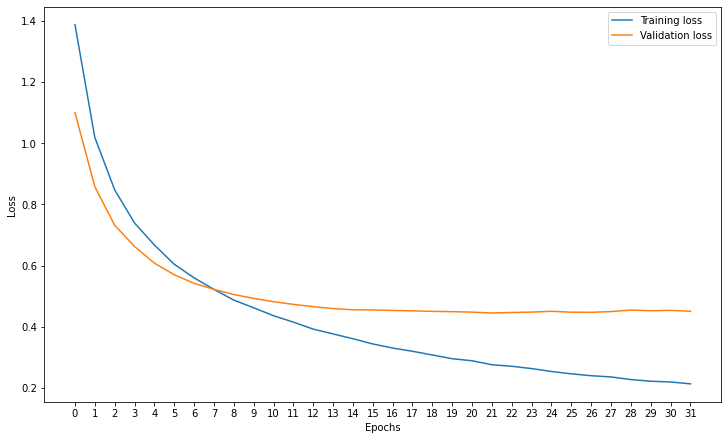

In [57]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
# index_min_val_loss = np.argmin(history.history["val_loss"])
# min_val_loss = history.history["val_loss"][index_min_val_loss]
# ax.plot([index_min_val_loss], [min_val_loss], marker="o", color="C1")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(len(history.history["loss"])))
ax.legend()
plt.savefig("loss.png")

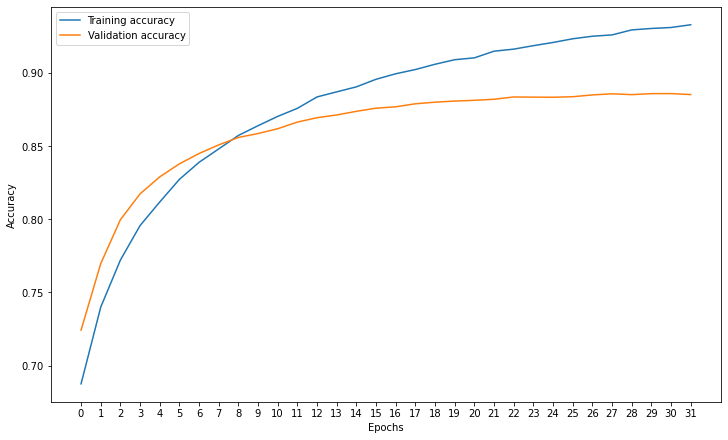

In [58]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

ax.plot(history.history["accuracy"], label="Training accuracy")
ax.plot(history.history["val_accuracy"], label="Validation accuracy")
# index_max_val_accuracy = np.argmax(history.history["val_accuracy"])
# max_val_accuracy = history.history["val_accuracy"][index_min_val_loss]
# ax.plot([index_max_val_accuracy], [max_val_accuracy], marker="o", color="C1")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(len(history.history["accuracy"])))
ax.legend()
plt.savefig("accuracy.png")

In [59]:
metrics = model.evaluate(test_dataset)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

63/63 [==============================] - 5s 61ms/step - loss: 0.4577 - accuracy: 0.8834
loss    : 0.4577
accuracy: 0.8834


In [60]:
y_true = []
for tokens, labels in test_dataset:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=2)

y_pred_raveled = y_pred[y_true != 0]
y_true_raveled = y_true[y_true != 0]

accuracy = accuracy_score(y_true_raveled, y_pred_raveled)
precision = precision_score(y_true_raveled, y_pred_raveled, average="macro")
recall = recall_score(y_true_raveled, y_pred_raveled, average="macro")
f1score = f1_score(y_true_raveled, y_pred_raveled, average="macro")
print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

63/63 [==============================] - 5s 70ms/step
accuracy : 0.8834
precision: 0.6878
recall   : 0.6349
F1       : 0.6560


C:\Users\Eduard\miniconda3\envs\licenta\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


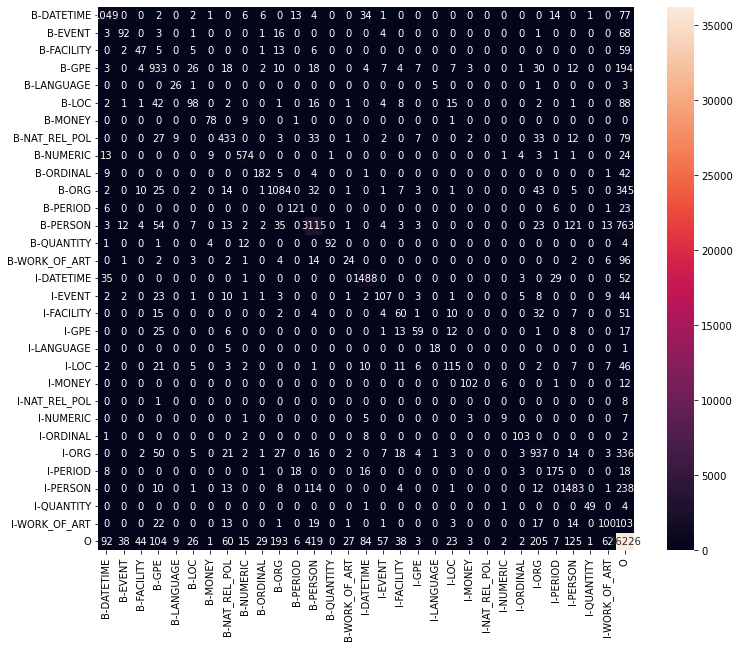

In [69]:
matrix = confusion_matrix(y_true_raveled, y_pred_raveled)
df = pd.DataFrame(matrix, index=unique_labels, columns=unique_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")

In [62]:
class SentencePreprocesser(tf.keras.layers.Layer):
    def __init__(self, tokenizer, packer):
        super(SentencePreprocesser, self).__init__()
        self.tokenizer = tokenizer
        self.packer = packer
    
    def call(self, inputs):
        tokens = self.tokenizer(inputs)
        tokens = tokens.merge_dims(-2, -1)
        tokens = tf.expand_dims(tokens, axis=0)
        tokens = packer([tokens])
        return tokens
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "tokenizer": self.tokenizer,
            "packer": self.packer
        })
        return config

In [63]:
model.compile()

inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = SentencePreprocesser(tokenizer, packer)(inputs)
outputs = model(x)
ner_model = tf.keras.Model(inputs=inputs, outputs=outputs)
ner_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 sentence_preprocesser_1 (Sente  {'input_type_ids':   0          ['input_8[0][0]']                
 ncePreprocesser)               (1, 30),                                                          
                                 'input_word_ids':                                                
                                (1, 30),                                                          
                                 'input_mask': (1,                                                
                                30)}                                                        

In [64]:
ner_model.compile()
ner_model.save("ner_model")

INFO:tensorflow:Assets written to: ner_model\assets


INFO:tensorflow:Assets written to: ner_model\assets


In [65]:
# !zip -r ner_model.zip ner_model/

In [66]:
# from google.colab import files
# files.download("ner_model.zip")
# files.download("loss.png")
# files.download("accuracy.png")
# files.download("confusion_matrix.png")